## Mathematical Basis of SVM
SVM corresponds to the optimization of

$$\min_{w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i$$

under the constraints:
$$ y_i (w^T \phi(x_i) + b) \geq 1 - \zeta_i$$
$$\zeta_i \geq 0$$ for all $$i = 1, \dots, n$$


This corresponds to finding a plane in the higher dimensional space that maximises the margin/ the distance between the two clusters. The plane is set right in the middle between the two closest points of the clusters and the margin is 2* the distance of one of these points to the plane. $w^T \phi(x_i) + b = 0$ defines a plane in the transformed space $\phi(x)$. The distance of a point P to that plane is
$$\text{Distance} = \frac{|w^T \phi(P) + b|}{\|w\|}$$
Since by definition we want the distance to the nearest points of the clusters to be 1 the overall margin is:
$$\frac{1}{\|w\|} + \frac{1}{\|w\|} = \frac{2}{\|w\|}$$

In machine learning we want to minimize a loss instead of maximizing the objective which is why the equivalent formulation of minimising $\frac{1}{2} w^T w$ instead of maximising $\frac{2}{\|w\|}$ is used. $y_i$ are the labels for the two clusters. The label is 1 for all points of the first and -1 for all of the second cluster. $ y_i (w^T \phi(x_i) + b) \geq 1$ therefore means that for all the possible planes we are only looking at ones that have one cluster at one side and one on the other (the function $w^T \phi(x_i) + b$ is negative for one and positive for the other side). Since in reality some datapoints will lie nearer to the other cluster then to their own we need to modify this program slightly by introducing slack variables $\zeta_i$ The slack variables take different values depending on the relation to the margin: $\zeta_i = 0$ means that the point lies on the correct side of the margin, $0 < \zeta_i \leq 1$ that it is inside the margin but on the right side and $\zeta_i > 1$ that is is completly misclassified. The loss is then modified such that the margin is maximized while the sum of mistakes is minimized, the relation between both goals regulated by C.

Instead of transforming every point x into the higher dimensional space $\phi(x)$ and then calculating the scalar products it is easier to use a kernel function $K(x_i, x_j)$ that calculates the scalar product in the higher dimensional space directly.

## Linear Kernel -- train and validate

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os

def load_dataset(dog_csv, chicken_csv):
    df_dogs = pd.read_csv(dog_csv)
    df_chicken = pd.read_csv(chicken_csv)
    df_dogs['label'] = 0
    df_chicken['label'] = 1
    df = pd.concat([df_dogs, df_chicken], ignore_index=True)
    cols_to_drop = ['filename', 'mask_source', 'label']
    existing_drop = [c for c in cols_to_drop if c in df.columns]
    y = df['label']
    X = df.drop(columns=existing_drop)
    X = X.reindex(sorted(X.columns), axis=1)
    return X, y


folder_train = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/train"
folder_val = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test/Validation"
folder_test = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test"

train_dogs_path = os.path.join(folder_train,"dog_features.csv")
train_ckicken_path = os.path.join(folder_train,"chicken_features.csv")
val_dogs_path = os.path.join(folder_val,"dog_features.csv")
val_chicken_path = os.path.join(folder_val,"chicken_features.csv")


# Loading data
X_train, y_train = load_dataset(train_dogs_path, train_ckicken_path)
X_val, y_val     = load_dataset(val_dogs_path, val_chicken_path)

# Scaling of the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Training of SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)


val_pred = svm_model.predict(X_val_scaled)
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.2f}")
print(classification_report(y_val, val_pred, target_names=['Hund', 'Chicken']))


Validation Accuracy: 0.80
              precision    recall  f1-score   support

        Hund       0.91      0.67      0.77       300
     Chicken       0.74      0.94      0.83       300

    accuracy                           0.80       600
   macro avg       0.83      0.80      0.80       600
weighted avg       0.83      0.80      0.80       600



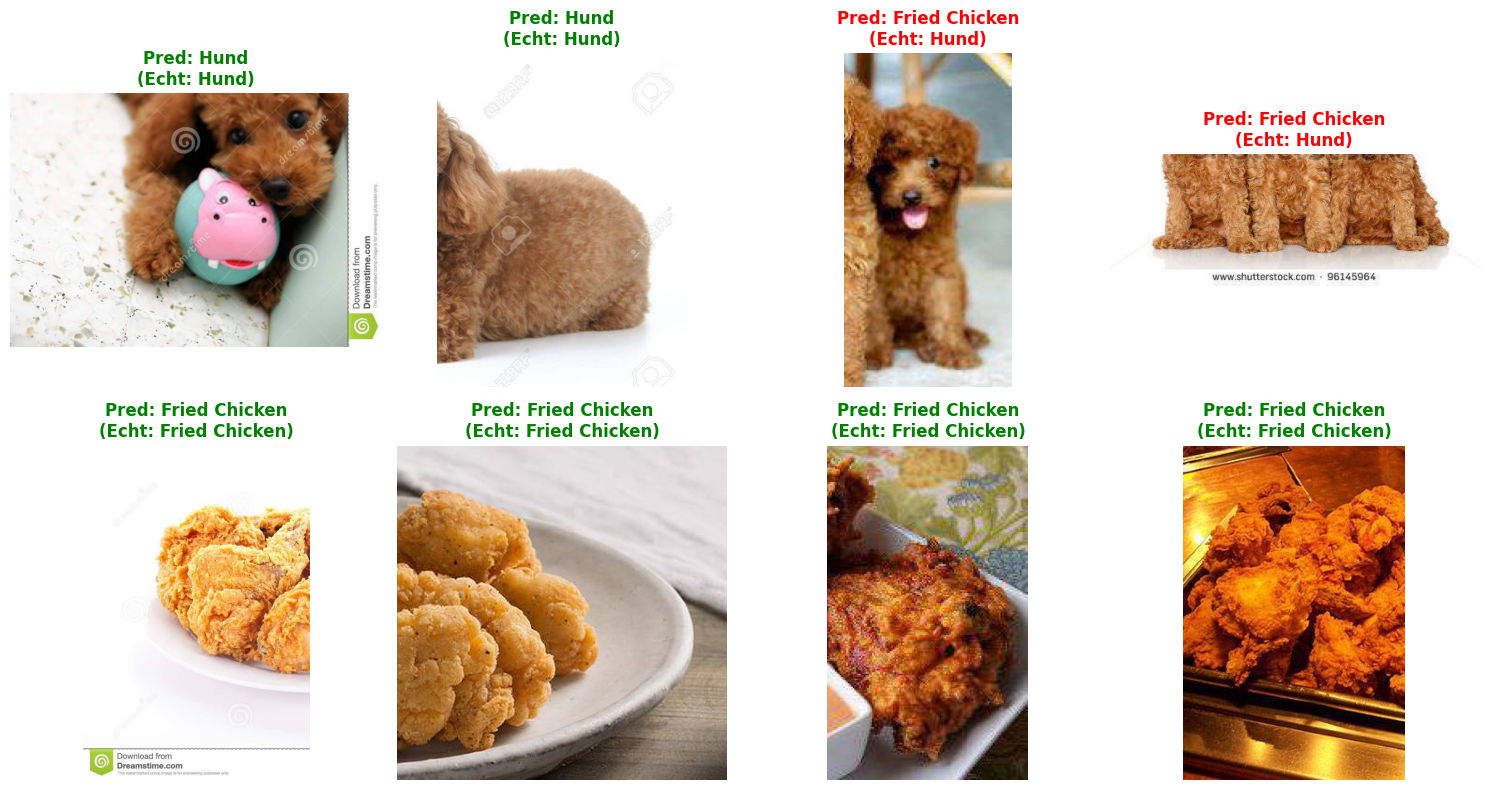

In [ ]:
# Visualisation

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import numpy as np

def visualize_random_predictions(n_per_class=3):
    df_val_dogs = pd.read_csv(val_dogs_path)
    df_val_chicken = pd.read_csv(val_chicken_path)
    df_val_dogs['true_label'] = 0  # Hund
    df_val_chicken['true_label'] = 1  # Chicken
    sample_dogs = df_val_dogs.sample(min(n_per_class, len(df_val_dogs)))
    sample_chicken = df_val_chicken.sample(min(n_per_class, len(df_val_chicken)))
    
    samples = pd.concat([sample_dogs, sample_chicken], ignore_index=True)
    cols_to_drop = ['filename', 'mask_source', 'label', 'true_label','is_fallback']
    existing_cols = [c for c in cols_to_drop if c in samples.columns]
    
    X_sample = samples.drop(columns=existing_cols)
    X_sample = X_sample.reindex(sorted(X_sample.columns), axis=1)
    
    X_sample_scaled = scaler.transform(X_sample)
    predictions = svm_model.predict(X_sample_scaled)
    
    label_map = {0: 'Hund', 1: 'Fried Chicken'}
    
    total_images = len(samples)
    cols = n_per_class  
    rows = 2            
    
    plt.figure(figsize=(15, 8))
    
    for i, (index, row) in enumerate(samples.iterrows()):
        filename = row['filename']
        true_label = row['true_label']
        pred_label = predictions[i]
        
        img_path = os.path.join(folder_val, filename)
        
        if not os.path.exists(img_path):
             subfolder = "dog" if true_label == 0 else "chicken" 
             img_path = os.path.join(folder_val, subfolder, filename)
             
        plt.subplot(rows, cols, i + 1)
        
        try:
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            
            color = 'green' if true_label == pred_label else 'red'
            title_text = f"Pred: {label_map[pred_label]}\n(Echt: {label_map[true_label]})"
            plt.title(title_text, color=color, fontsize=12, fontweight='bold')
            
        except FileNotFoundError:
            plt.text(0.5, 0.5, "Bild nicht\ngefunden", ha='center')
            plt.title(f"File: {filename}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_predictions(n_per_class=4)

In [ ]:
# Final testing
test_dogs_path   = os.path.join(folder_test,"dog_features.csv")
test_chicken_path = os.path.join(folder_test,"chicken_features.csv")
X_test, y_test   = load_dataset(test_dogs_path, test_chicken_path)

X_test_scaled = scaler.transform(X_test)
test_pred = svm_model.predict(X_test_scaled)

print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, test_pred, target_names=['Hund', 'Chicken']))

Test Accuracy: 0.80

Classification Report (Test):
              precision    recall  f1-score   support

        Hund       0.89      0.68      0.77       199
     Chicken       0.74      0.92      0.82       200

    accuracy                           0.80       399
   macro avg       0.81      0.80      0.79       399
weighted avg       0.81      0.80      0.79       399



## Non-Linear Kernels + Parameter-searching

--- Best Parameter Settings ---
C: 700.0
Gamma: 0.01
Validation Accuracy: 0.83


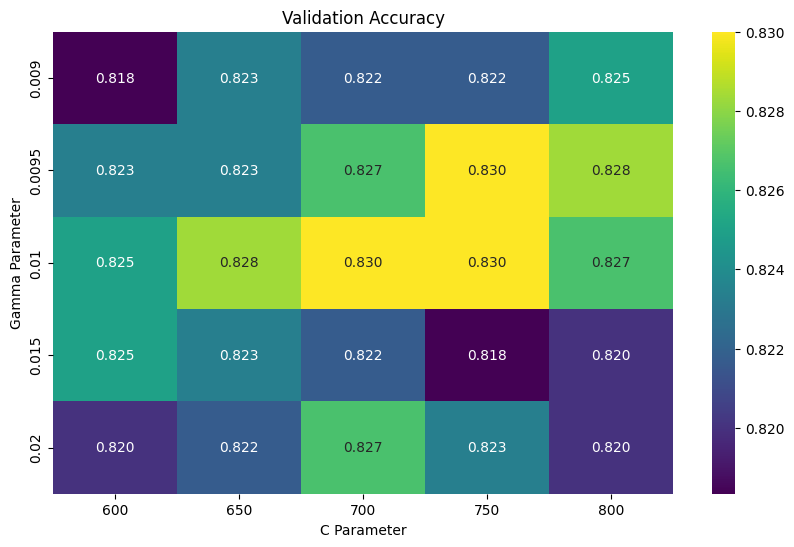


Classification report of the best model:
Validation Accuracy: 0.830
              precision    recall  f1-score   support

        Hund       0.89      0.75      0.82       300
     Chicken       0.78      0.91      0.84       300

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_dataset(dog_csv, chicken_csv):
    df_dogs = pd.read_csv(dog_csv)
    df_chicken = pd.read_csv(chicken_csv)
    df_dogs['label'] = 0
    df_chicken['label'] = 1
    df = pd.concat([df_dogs, df_chicken], ignore_index=True)
    cols_to_drop = ['filename', 'mask_source', 'label']
    existing_drop = [c for c in cols_to_drop if c in df.columns]
    y = df['label']
    X = df.drop(columns=existing_drop)
    X = X.reindex(sorted(X.columns), axis=1)
    return X, y

folder_train = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/train"
folder_val = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test/Validation"

train_dogs_path = os.path.join(folder_train,"dog_features.csv")
train_ckicken_path = os.path.join(folder_train,"chicken_features.csv")
val_dogs_path = os.path.join(folder_val,"dog_features.csv")
val_chicken_path = os.path.join(folder_val,"chicken_features.csv")

# load data
X_train, y_train = load_dataset(train_dogs_path, train_ckicken_path)
X_val, y_val     = load_dataset(val_dogs_path, val_chicken_path)

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# defining the searching space --> final version after iterative refinement
# the other parameter searches are visualised in the parameter_search_svm.jpg files
param_grid = {
    'C': [600, 650, 700, 750, 800], 
    'gamma': [0.009, 0.0095, 0.01, 0.015, 0.02],
    'kernel': ['rbf'] 
}


results = []

# parameter search
for params in ParameterGrid(param_grid):

    svm = SVC(**params, random_state=42)
    svm.fit(X_train_scaled, y_train)
    val_acc = svm.score(X_val_scaled, y_val)
    results.append({'C': params['C'],'gamma': params['gamma'],'val_accuracy': val_acc})

results_df = pd.DataFrame(results)

best_row = results_df.loc[results_df['val_accuracy'].idxmax()]
print("--- Best Parameter Settings ---")
print(f"C: {best_row['C']}")
print(f"Gamma: {best_row['gamma']}")
print(f"Validation Accuracy: {best_row['val_accuracy']:.2f}")


pvt = results_df.pivot(index='gamma', columns='C', values='val_accuracy')

#plotting results
plt.figure(figsize=(10, 6))
sns.heatmap(pvt, annot=True, fmt=".3f", cmap='viridis')
plt.title('Validation Accuracy')
plt.xlabel('C Parameter')
plt.ylabel('Gamma Parameter')
plt.savefig(os.path.join(folder_train,"parameter_search_svm3.jpg"))
plt.show()


# evaluating best model
best_svm = SVC(kernel='rbf', C=best_row['C'], gamma=best_row['gamma'], random_state=42)
best_svm.fit(X_train_scaled, y_train)

print("\nClassification report of the best model:")
val_pred = best_svm.predict(X_val_scaled)
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.3f}")
print(classification_report(y_val, val_pred, target_names=['Hund', 'Chicken']))


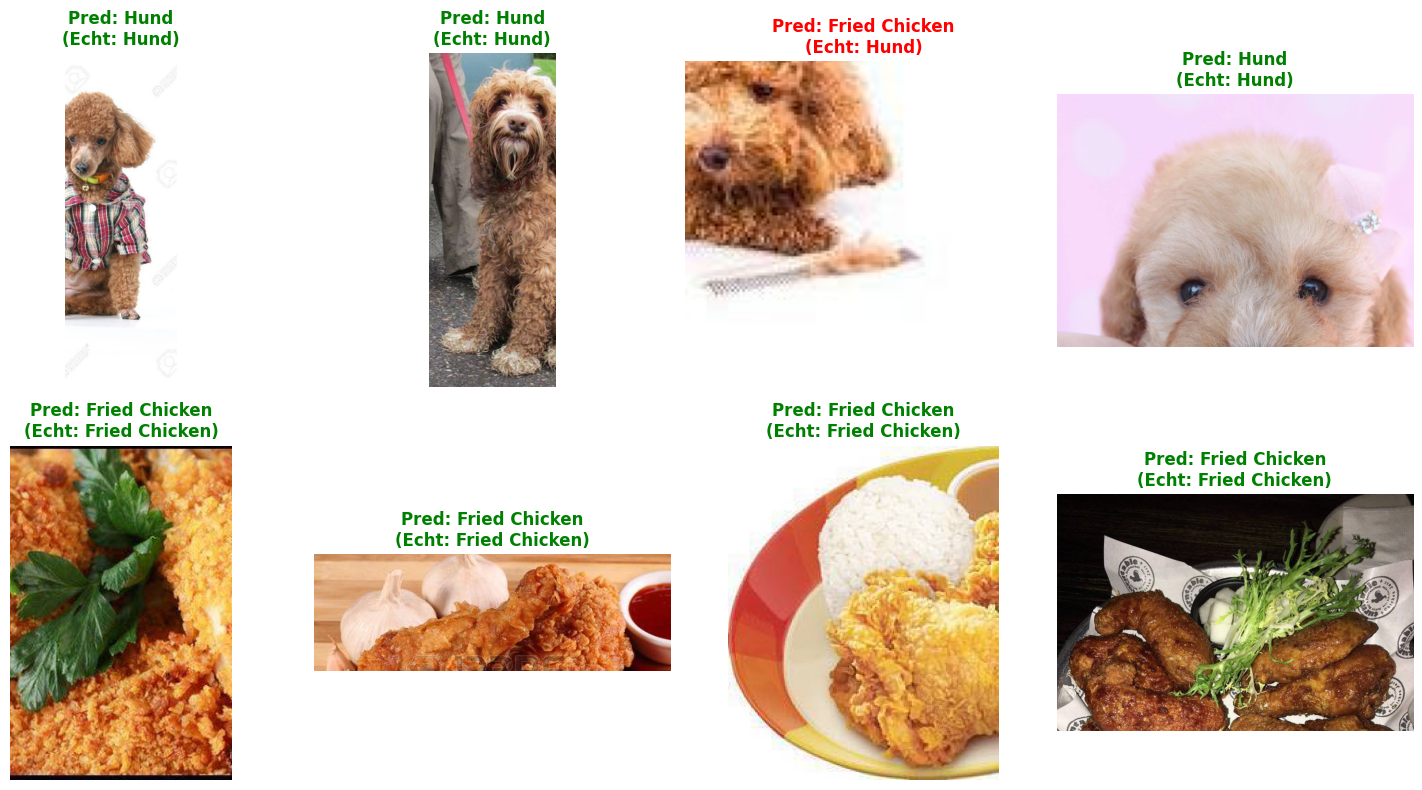

In [20]:
# Visualisation again for the best model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import os
import pandas as pd
import numpy as np

def visualize_random_predictions(n_per_class=3):
    df_val_dogs = pd.read_csv(val_dogs_path)
    df_val_chicken = pd.read_csv(val_chicken_path)
    df_val_dogs['true_label'] = 0  # Hund
    df_val_chicken['true_label'] = 1  # Chicken
    sample_dogs = df_val_dogs.sample(min(n_per_class, len(df_val_dogs)))
    sample_chicken = df_val_chicken.sample(min(n_per_class, len(df_val_chicken)))
    
    samples = pd.concat([sample_dogs, sample_chicken], ignore_index=True)
    cols_to_drop = ['filename', 'mask_source', 'label', 'true_label']
    existing_cols = [c for c in cols_to_drop if c in samples.columns]
    
    X_sample = samples.drop(columns=existing_cols)
    X_sample = X_sample.reindex(sorted(X_sample.columns), axis=1)
    
    X_sample_scaled = scaler.transform(X_sample)
    predictions = svm_model.predict(X_sample_scaled)
    
    label_map = {0: 'Hund', 1: 'Fried Chicken'}
    
    total_images = len(samples)
    cols = n_per_class  
    rows = 2            
    
    plt.figure(figsize=(15, 8))
    
    for i, (index, row) in enumerate(samples.iterrows()):
        filename = row['filename']
        true_label = row['true_label']
        pred_label = predictions[i]
        
        img_path = os.path.join(folder_val, filename)
        
        if not os.path.exists(img_path):
             subfolder = "dog" if true_label == 0 else "chicken" 
             img_path = os.path.join(folder_val, subfolder, filename)
             
        plt.subplot(rows, cols, i + 1)
        
        try:
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            
            color = 'green' if true_label == pred_label else 'red'
            title_text = f"Pred: {label_map[pred_label]}\n(Echt: {label_map[true_label]})"
            plt.title(title_text, color=color, fontsize=12, fontweight='bold')
            
        except FileNotFoundError:
            plt.text(0.5, 0.5, "Bild nicht\ngefunden", ha='center')
            plt.title(f"File: {filename}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

best_parameters = dict(best_row)
folder_train = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/train"
folder_val = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test/Validation"
folder_test = "/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test"

train_dogs_path = os.path.join(folder_train,"dog_features.csv")
train_ckicken_path = os.path.join(folder_train,"chicken_features.csv")
val_dogs_path = os.path.join(folder_val,"dog_features.csv")
val_chicken_path = os.path.join(folder_val,"chicken_features.csv")


# Loading data
X_train, y_train = load_dataset(train_dogs_path, train_ckicken_path)
X_val, y_val     = load_dataset(val_dogs_path, val_chicken_path)

# Scaling of the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Training of SVM
svm_model = SVC(kernel='rbf', C=best_parameters["C"], gamma=best_parameters["gamma"])
svm_model.fit(X_train_scaled, y_train)


val_pred = svm_model.predict(X_val_scaled)
# print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.2f}")
# print(classification_report(y_val, val_pred, target_names=['Hund', 'Chicken']))

visualize_random_predictions(n_per_class=4)

In [21]:
# Final Testing again

test_dogs_path   = os.path.join(folder_test,"dog_features.csv")
test_chicken_path = os.path.join(folder_test,"chicken_features.csv")
X_test, y_test   = load_dataset(test_dogs_path, test_chicken_path)

X_test_scaled = scaler.transform(X_test)
test_pred = svm_model.predict(X_test_scaled)

print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, test_pred, target_names=['Hund', 'Chicken']))

Test Accuracy: 0.825

Classification Report (Test):
              precision    recall  f1-score   support

        Hund       0.89      0.74      0.81       199
     Chicken       0.78      0.91      0.84       200

    accuracy                           0.82       399
   macro avg       0.83      0.82      0.82       399
weighted avg       0.83      0.82      0.82       399



## Evaluation: Confusion Matrix, ROC Curve and Error Analysis

 **Some general observations:**
- the "is_fallback" column doesn't make a difference for the overall result which is kinda surprising since for this images neither the otsu thresholding nor the Rembg model could segment the dog/chicken appropriatly and the whole image was classified instad
- Validation accuracy of linear and rbf kernels -- $\exp(-\gamma |x-x'|²)$ -- are quite similar: 0.8 zu 0.83
-  other kernels (polynomial, sigmoid tanh) result in the same validation accuracy as rbf
- accuracy on the testing data set is slightly lower than on the validation data set for the same parameters --> could be a sign for ligth overfitting, parameter C=700 also speaks for this, the effect is quite low though

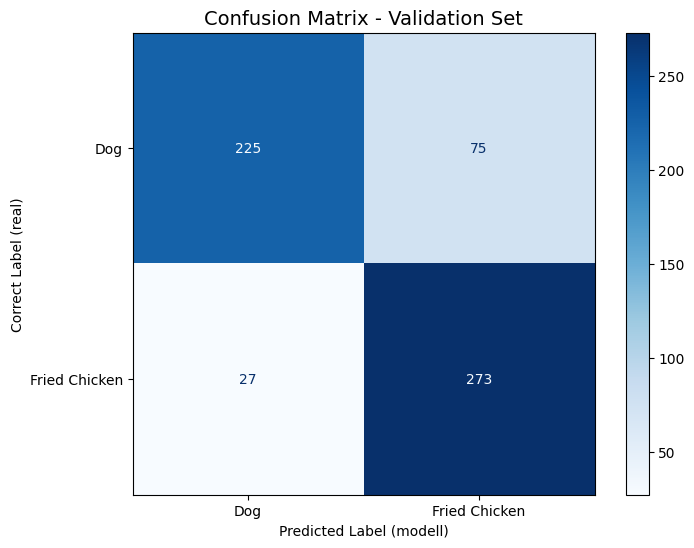

Overall AUC: 0.9163555555555556


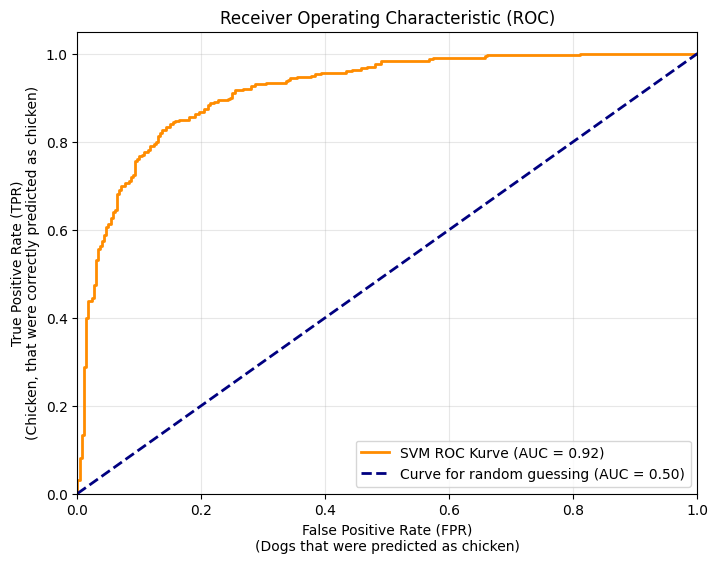

In [ ]:
# Confusion Matrix and ROC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Confusion Matrix
val_pred = svm_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dog', 'Fried Chicken'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)

plt.title('Confusion Matrix - Validation Set', fontsize=14)
plt.xlabel('Predicted Label (modell)')
plt.ylabel('Correct Label (real)')
plt.show()

#The confusion matrix shows for the dog prediction a precision of 0.892 and a recall:0.75. Obviously the model is confusing 
# more dogs with fried chicken than the other way around. Still the high values agree with the overall accuracy



# ROC-curve and AUC

# variable for changing the FPR/TPR and therefore for determinin the ROC curve
y_scores = svm_model.decision_function(X_val_scaled)

fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

print(f"Overall AUC: {roc_auc}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVM ROC Kurve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Curve for random guessing (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)\n(Dogs that were predicted as chicken)')
plt.ylabel('True Positive Rate (TPR)\n(Chicken, that were correctly predicted as chicken)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#The AUC is very high for our data and significantly outperforms a classifier that guesses randomly, as is shown in the curve

In [23]:
# Copying the wrongly classified images to another folder for Error Analysis

import os
import shutil
import pandas as pd


error_folder = os.path.join(folder_val, "Falsely_Classified")
os.makedirs(error_folder, exist_ok=True)

df_val_dogs = pd.read_csv(val_dogs_path)
df_val_chicken = pd.read_csv(val_chicken_path)
df_val_dogs['true_label'] = 0
df_val_chicken['true_label'] = 1
df_val_full = pd.concat([df_val_dogs, df_val_chicken], ignore_index=True)

df_val_full['pred_label'] = val_pred

errors_df = df_val_full[df_val_full['true_label'] != df_val_full['pred_label']]

print(f"Found errors: {len(errors_df)}. Start Copying...")

label_names = {0: "Dog", 1: "Chicken"}
copied = 0
not_found = 0

for index, row in errors_df.iterrows():
    filename = row['filename']
    true_lbl = row['true_label']
    pred_lbl = row['pred_label']
    
    source_path = os.path.join(folder_val, "dog" if true_lbl == 0 else "chicken", filename)

    if source_path:
        new_filename = f"Real_{label_names[true_lbl]}_Pred_{label_names[pred_lbl]}_{filename}"
        target_path = os.path.join(error_folder, new_filename)
        
        shutil.copy(source_path, target_path)
        copied += 1
    else:
        not_found += 1

print(f"\nSuccesfully copied: {copied}")
if not_found > 0:
    print(f"WARNING: {not_found} images have not been found in {folder_val}.")
print(f"The images are now in:\n{error_folder}")

Found errors: 102. Start Copying...

Succesfully copied: 102
The images are now in:
/home/jona/Schreibtisch/Studium/Semester3/Bioimaging/Practical_week/dog-learning/data/dog_chicken/test/Validation/Falsely_Classified


It is not easy to see what kind of images properties confused the model the most. Generally we used images that have been cropped and often the dogs that were cropped right in half were mistaken as a fried chicken:

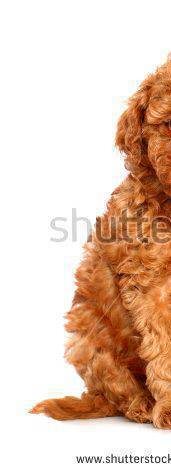

Another feature that seems to benefit wrong classification is a fur color similar to that of the chicken:

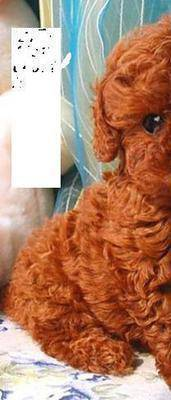

Even though there are examples of dogs with a highly different fur color that still were misclassified:

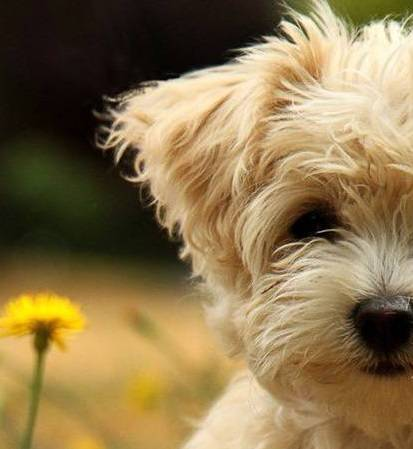